# Stop Colab from disconnecting

Instructions from: https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting



> Set a javascript interval to click on the connect button every 60 seconds. Open developer-settings (in your web-browser) with Ctrl+Shift+I (for Windows. For Mac: Option+Command+I) then click on console tab and type this on the console prompt. 
```
function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```

ta-da!



# Data Download

Followed instructions from: https://www.kaggle.com/general/74235

In [1]:
# Install kaggle
!pip install -q kaggle
from google.colab import files
!mkdir ~/.kaggle 
# Upload kaggle API token to download data directly from kaggle 
files.upload()
# Upload my Kaggle API json file, then change permissions
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:

# Create a folder for uploading files
!mkdir w207
# Change working directory 
%cd w207  
# Take a look at kaggle datasets available
# !kaggle datasets list
# Download facial keypoints detection
!kaggle competitions download -c facial-keypoints-detection


/content/w207
 56% 9.00M/16.0M [00:00<00:00, 79.2MB/s]
100% 16.0M/16.0M [00:00<00:00, 102MB/s] 
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 182MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 118MB/s]
 72% 43.0M/60.1M [00:00<00:00, 96.8MB/s]
100% 60.1M/60.1M [00:00<00:00, 152MB/s] 


In [3]:
%ls

IdLookupTable.csv  SampleSubmission.csv  test.zip  training.zip


# Set Up

Found a tutorial. Follow what's in there.

https://www.kaggle.com/fmak95/facial-keypoint-detection

In [0]:
from tensorflow.keras.layers import InputLayer, Dense, Activation, Dropout, Flatten, AveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization


keras version: 2.3.0-tf
pandas version: 1.0.3


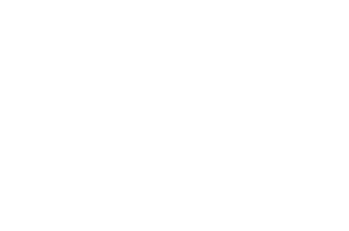

In [4]:
# Colab by default uses 1.x, so upgrade here
%tensorflow_version 2.x

import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import math
from tensorflow import keras 

# import keras.layers 
import tensorflow.python.keras.layers 
# import keras.models 
import tensorflow.python.keras.models as models
from tensorflow.keras.layers import InputLayer, Dense, Activation, Dropout, Flatten, AveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization


from tensorflow.python.keras import Sequential
# from keras import Sequential

# from keras.losses import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd

print(f"keras version: {keras.__version__}")
print(f"pandas version: {pd.__version__}")
%matplotlib inline
plt.style.use('ggplot')
plt.axis('off')
IMAGE_WIDTH = 96

np.random.seed(0)

In [5]:
# load data
train_data = pd.read_csv("training.zip")
test_data = pd.read_csv("test.zip")
meta_data = pd.read_csv("IdLookupTable.csv")
# for now, use values from the previous rows
train_data.fillna(method="ffill", inplace = True)

def convert_df_to_np_2d(df: pd.Series, image_size: int) -> np.ndarray:
  dataset = np.vstack(train_data["Image"].apply(lambda row:np.fromstring(row,sep=' ')).to_numpy())
  dataset = dataset.astype(np.float32)
  dataset = dataset.reshape(-1,image_size,image_size,1)
  # HL addition--change to tensor 
  dataset = tf.convert_to_tensor(dataset, np.float32)
  return dataset

X_train = convert_df_to_np_2d(train_data["Image"], IMAGE_WIDTH)
print(X_train.shape)


(7049, 96, 96, 1)


In [6]:
y_train = np.delete(train_data.to_numpy(),-1,axis=1) #removing the last column(Image)
# Instead of numpy, change to tensor 
y_train = tf.convert_to_tensor(y_train, np.float32)
y_train.shape

TensorShape([7049, 30])

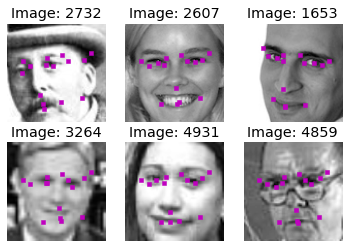

In [7]:
def show_image(img: np.ndarray):
  plt.axis('off')
  plt.imshow(img,cmap="gray")
  plt.show()

def show_image_with_key_points(img: np.ndarray, key_points: np.ndarray, image_number, axis):
  axis.axis('off')
  axis.imshow(img[:,:,0],cmap="gray")
  axis.scatter(key_points[0:30:2],key_points[1:30:2], s=10,marker=',',c='m')
  axis.set_title(f"Image: {image_number}")

def show_multiple_samples(image_set: np.ndarray, feature_set: np.ndarray, number_of_images: int, images_per_row = 3):
  fig, axis = plt.subplots(number_of_images//images_per_row, images_per_row)
  for i in range(number_of_images):
    image_number = np.random.randint(0, image_set.shape[0])
    show_image_with_key_points(image_set[image_number], feature_set[image_number], 
                              image_number , axis[i//images_per_row,
                                                  i%images_per_row])
show_multiple_samples(X_train,y_train, 6)

In [8]:
test_data.fillna(method="ffill", inplace = True)
test_data.head(5).T
X_test = convert_df_to_np_2d(test_data["Image"], IMAGE_WIDTH)
print(X_test.shape)

(7049, 96, 96, 1)


# 3. BaseLine Model using Naive LeNet-5

HL note: Instead of keras.Sequential or keras.layers, I've imported the `tensorflow.python.keras` versions to go with the newer version of Tensorflow

In [0]:
def create_naive_LeNet5_model(input_shape):
  print(f"Initializing LeNet5 model with input-size: {input_shape}")
  # model = keras.Sequential()    # Don't use multi-backend keras anymore
  model = Sequential()
  model.add(tensorflow.python.keras.layers.InputLayer(input_shape))
  model.add(tensorflow.python.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
  model.add(tensorflow.python.keras.layers.AveragePooling2D())
  model.add(tensorflow.python.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(tensorflow.python.keras.layers.AveragePooling2D())
  model.add(tensorflow.python.keras.layers.Flatten())
  model.add(tensorflow.python.keras.layers.Dense(units=120, activation='relu'))
  model.add(tensorflow.python.keras.layers.Dense(units=84, activation='relu'))
  model.add(tensorflow.python.keras.layers.Dense(units=30))
  return model


In [10]:

LeNet5_model = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

Initializing LeNet5 model with input-size: (96, 96, 1)


In [11]:
# #train it!
result = LeNet5_model.fit(X_train,y_train,epochs = 50,batch_size = 256,validation_split = 0.2)

Epoch 1/50
23/23 [==============================] - 1s 23ms/step - loss: 1022.4599 - mae: 22.5017 - val_loss: 177.8585 - val_mae: 10.3752
Epoch 2/50
23/23 [==============================] - 0s 14ms/step - loss: 158.7504 - mae: 9.6186 - val_loss: 125.7304 - val_mae: 8.3304
Epoch 3/50
23/23 [==============================] - 0s 14ms/step - loss: 119.0604 - mae: 8.2009 - val_loss: 132.2241 - val_mae: 8.7390
Epoch 4/50
23/23 [==============================] - 0s 14ms/step - loss: 112.5522 - mae: 8.0552 - val_loss: 105.1566 - val_mae: 7.5851
Epoch 5/50
23/23 [==============================] - 0s 14ms/step - loss: 95.7897 - mae: 7.3927 - val_loss: 106.2131 - val_mae: 7.6699
Epoch 6/50
23/23 [==============================] - 0s 14ms/step - loss: 94.6875 - mae: 7.2585 - val_loss: 91.5778 - val_mae: 7.0231
Epoch 7/50
23/23 [==============================] - 0s 14ms/step - loss: 86.7022 - mae: 6.9053 - val_loss: 99.9846 - val_mae: 7.4680
Epoch 8/50
23/23 [==============================] - 0s 14

In [17]:
type(y_train)

tensorflow.python.framework.ops.EagerTensor

In [0]:
y_test = LeNet5_model.predict(X_test)

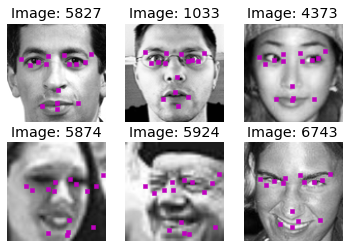

In [19]:
show_multiple_samples(X_test, y_test, 6)

See image 5924. Some pictures seem smaller?

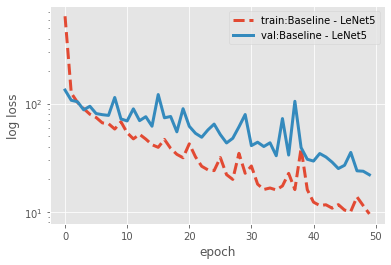

In [20]:
# let's plot validation and train loss
def plot_history(history, name, RMSE_TF=False):
  loss = history['loss']
  val_loss = history['val_loss']
  plt.plot(figsize=(15,10))
  plt.plot(loss,"--",linewidth=3,label="train:"+name)
  plt.plot(val_loss,linewidth=3,label="val:"+name)
  plt.yscale("log")
  plt.xlabel("epoch")
  plt.ylabel("log loss")
  plt.legend()
  plt.grid(True)
plot_history(result.history, "Baseline - LeNet5")

We're comparing the loss between train data and validation data. In the `fit` function, we held 20% of the data back to use as a validation set. Instead of accuracy, we're using loss as a measure of performance, because the facial feature point is at a specific coordinate and it's practically impossible to get that exactly right. 

Anyway, you can see that both the losses decrease over epochs. And since the training set data is what we're using to predict the training set, the loss becomes really really small on that dataset.

In [7]:
%cd w207

/content/w207


# Julia's

In [20]:
train_df = pd.read_csv("training.zip")
test_df = pd.read_csv("test.zip")
meta_data = pd.read_csv("IdLookupTable.csv")

train_data = [x.split(' ') for x in train_df['Image'].tolist()]
train_data = np.asarray(train_data).astype(int).reshape(-1, IMAGE_WIDTH, IMAGE_WIDTH, 1)
print('train data shape:', train_data.shape)

# make a copy of the dataframe before deleting column so the code can be run repeatedly during testing

# for now, use values from the previous rows
train_df2 = train_df.copy()
train_df2.fillna(method="ffill", inplace = True)

del train_df2['Image']
train_output = train_df2.to_numpy()
print('train output shape:', train_output.shape)

X_train = train_data[:6000]
Y_train = train_output[:6000]

X_dev = train_data[6000:]
Y_dev = train_output[6000:]

X_test = [x.split(' ') for x in test_df['Image'].tolist()]
X_test = np.asarray(X_test).astype(int).reshape(-1, IMAGE_WIDTH, IMAGE_WIDTH, 1)
print('test data shape:', X_test.shape)

train data shape: (7049, 96, 96, 1)
train output shape: (7049, 30)
test data shape: (1783, 96, 96, 1)


In [9]:
X_dev.shape

(1049, 96, 96, 1)

In [22]:
from keras.preprocessing.image import ImageDataGenerator

# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).

datagen = ImageDataGenerator(width_shift_range=0.25, height_shift_range = 0.25)
datagen.fit(X_train)

Using TensorFlow backend.


In [23]:
# Sang's fn but this time using augmented data 

LeNet5_model2 = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model2.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

result2 = LeNet5_model2.fit_generator(datagen.flow(X_train, Y_train, batch_size = 32), epochs = 50, steps_per_epoch = len(train_data) / 32)

Initializing LeNet5 model with input-size: (96, 96, 1)
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
221/220 [==============================] - 5s 22ms/step - loss: 278.5143 - mae: 10.6737
Epoch 2/50
221/220 [==============================] - 5s 22ms/step - loss: 115.4519 - mae: 8.1141
Epoch 3/50
221/220 [==============================] - 5s 22ms/step - loss: 108.3572 - mae: 7.8383
Epoch 4/50
221/220 [==============================] - 5s 22ms/step - loss: 96.1530 - mae: 7.3319
Epoch 5/50
221/220 [==============================] - 5s 22ms/step - loss: 80.7864 - mae: 6.7426
Epoch 6/50
221/220 [==============================] - 5s 22ms/step - loss: 61.6072 - mae: 5.8614
Epoch 7/50
221/220 [==============================] - 5s 22ms/step - loss: 38.7344 - mae: 4.6329
Epoch 8/50
221/220 [==============================] - 5s 22ms/step - loss: 29.5173 - mae: 4.0269
Epoch 9/50
221/220 [==============================] - 5s 22ms/step - loss: 23.2595 - mae:

In [26]:
X_dev.shape

(1049, 96, 96, 1)

In [27]:
X_dev[1].shape

(96, 96, 1)

In [28]:
X_dev[1, 1].shape

(96, 1)

In [29]:
X_dev[1:3].shape

(2, 96, 96, 1)

In [30]:
tf.gather_nd(X_dev, [[1], [3]]).shape

TensorShape([2, 96, 96, 1])

In [31]:
tf.gather_nd(X_dev, [[1, 3]]).shape

TensorShape([1, 96, 1])

In [32]:
tf.gather_nd(X_dev, [[i] for i in idx]).shape

NameError: ignored

In [33]:
# X_dev[np.array(idx),:,:,:]

# tf.gather_nd(X_dev, [1]) == X_dev[1]
(tf.gather_nd(X_dev, [[1, 2]]) == X_dev[[1, 2]]).shape

TensorShape([2, 96, 96, 1])

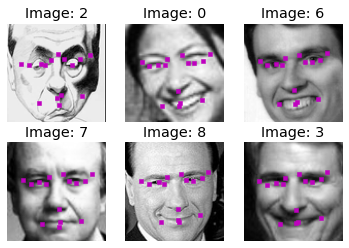

In [34]:
# predict and plot out some sample predictions

Y_dev_predicted = LeNet5_model2.predict(X_dev)

idx = np.random.randint(0, X_dev.shape[0], size = 9).tolist()
# plot_images(X_dev[np.array(idx)], Y_dev_predicted[np.array(idx)])

# This is the syntax for tf 2.0 and tf.keras that's compatible with it
show_multiple_samples(tf.gather_nd(X_dev, [[i] for i in idx]), 
                      tf.gather_nd(Y_dev_predicted, [[i] for i in idx]),
                      6)



In [35]:
for j in idx:
  show_image_with_key_points_hl(X_dev[j], Y_dev[j], image_number=j)


NameError: ignored

Huh that's a cartoon face

In [36]:
Y_dev_predicted.shape

(1049, 30)

In [37]:
LeNet5_model.evaluate(X_dev, Y_dev)

33/33 [==============================] - 0s 3ms/step - loss: 23.4171 - mae: 3.3946


[23.417133331298828, 3.394599437713623]

In [38]:
LeNet5_model2.evaluate(X_dev, Y_dev)

33/33 [==============================] - 0s 3ms/step - loss: 5.8763 - mae: 1.4438


[5.876262187957764, 1.4437603950500488]

In [0]:
# Julia added rotation
datagen2 = ImageDataGenerator(width_shift_range=0.25, height_shift_range = 0.25, rotation_range = 30)
datagen2.fit(X_train)

In [13]:
LeNet5_model3 = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model3.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

result3 = LeNet5_model3.fit_generator(datagen2.flow(X_train, Y_train, batch_size = 32), epochs = 50, steps_per_epoch = len(train_data) / 32)

Initializing LeNet5 model with input-size: (96, 96, 1)


KeyboardInterrupt: ignored

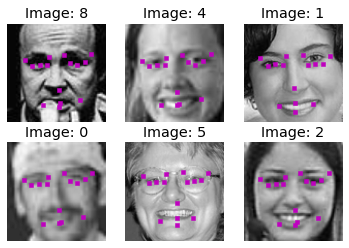

In [41]:
# predict and plot out some sample predictions

Y_dev_predicted = LeNet5_model3.predict(X_dev)

idx = np.random.randint(0, X_dev.shape[0], size = 9).tolist()
# plot_images(X_dev[np.array(idx)], Y_dev_predicted[np.array(idx)])

show_multiple_samples(tf.gather_nd(X_dev, [[i] for i in idx]), 
                      tf.gather_nd(Y_dev_predicted, [[i] for i in idx]),
                      6)



In [42]:
LeNet5_model3.evaluate(X_dev, Y_dev)

33/33 [==============================] - 0s 3ms/step - loss: 7.5347 - mae: 1.7714


[7.534668922424316, 1.7714118957519531]

In [0]:
?LeNet5_model3.evaluate()

In [44]:
LeNet5_model3.metrics_names

['loss', 'mae']

# HL Visualizing intermediate activation in Convolutional Neural Networks with Keras

* Medium post: https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0 
* GitHub version with full code: https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

> "In order to extract the feature maps we want to look at, we’ll create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, we’ll use the Keras class Model. A model is instantiated using two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors). The resulting class is a Keras model, just like the Sequential models, mapping the specified inputs to the specified outputs. What sets the Model class apart is that it allows for models with multiple outputs, unlike Sequential."

In [13]:
# This is the model I want to show the intermediate activations of. 

LeNet5_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 47, 47, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 22, 22, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               929400    
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [0]:
layer_outputs = [layer.output for layer in LeNet5_model.layers]


In [0]:
# models comes from: import tensorflow.python.keras.models as models 
# OR from keras import models for regular keras 
activation_model = models.Model(inputs=LeNet5_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
#activation_model.predict(X_dev) 

When fed an image input, this model returns the values of the layer activations in the original model

## Running the model in predict mode

In [48]:
X_dev.shape

(1049, 96, 96, 1)

In [19]:
#activation_model = models.Model(inputs=LeNet5_model.input, outputs=layer_outputs)
activations = activation_model.predict(x_dev) 

NameError: ignored

In [50]:
len(activations)

8

In [51]:
for layer in activations:
  print(layer.shape)

(1049, 94, 94, 6)
(1049, 47, 47, 6)
(1049, 45, 45, 16)
(1049, 22, 22, 16)
(1049, 7744)
(1049, 120)
(1049, 84)
(1049, 30)


In [52]:
# For instance, this is the activation of the first convolution layer for the image input:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1049, 94, 94, 6)


So our first layer is a 94 x 94 feature map with 6 channels. What do they look like?

In [0]:
# # I want to see every layer, actually.
# # Let's stick to image indexed 0

# def show_img_n_1stlayer(img_index, layer_index, layer_activation):
#   fig, axis = plt.subplots(1, 2)
#   fig.suptitle("Layer index:" + str(layer_index))
  
#   # First image is the original face
#   axis[0].imshow(X_dev[img_index][:, :, 0],cmap="gray")
#   axis[0].axis("off")

#   # Second image is the nth filter of the first layer 
#   axis[1].imshow(layer_activation[img_index, :, :, layer_index],cmap="gray")
#   axis[1].axis("off")

#   fig.show()


# for layer_index in range(0,6):
#   show_img_n_1stlayer(img_index = 0, layer_index=layer_index, layer_activation=first_layer_activation)

In [54]:
activations[2].shape

(1049, 45, 45, 16)

In [24]:
LeNet5_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 6)         60        
_________________________________________________________________
average_pooling2d_4 (Average (None, 47, 47, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 16)        880       
_________________________________________________________________
average_pooling2d_5 (Average (None, 22, 22, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               929400    
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [50]:
 max(6//15, 1)

1

In [0]:
?models.Model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 6)         60        
_________________________________________________________________
average_pooling2d_4 (Average (None, 47, 47, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 16)        880       
_________________________________________________________________
average_pooling2d_5 (Average (None, 22, 22, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               929400    
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

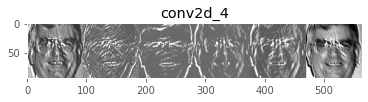

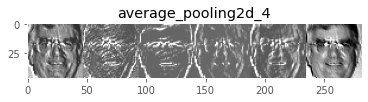

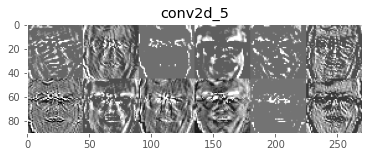

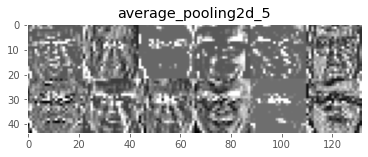

In [59]:
model = LeNet5_model2
imgnum=3

print(model.summary())
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_dev) 

layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 6    

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    ## Only if shape has 4 numbers. So ignore flattened/fully connected layers
    if len(layer_activation.shape) == 4:
      
      n_features = layer_activation.shape[-1] # Number of features in the feature map
      size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).

      
      n_cols =  n_features // images_per_row # Tiles the activation channels in this matrix
      display_grid = np.zeros((size * n_cols, images_per_row * size))

      for col in range(n_cols): # Tiles each filter into a big horizontal grid
          for row in range(images_per_row):
              channel_image = layer_activation[imgnum,   # image number
                                                :, :,
                                                col * images_per_row + row]
              # Post-processes the feature to make it visually palatable
              channel_image -= channel_image.mean() 
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size, # Displays the grid
                            row * size : (row + 1) * size] = channel_image
      scale = 1. / size
      plt.figure(figsize=(scale * max(display_grid.shape[1], 1),
                          scale * max(display_grid.shape[0], 1)))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap="gray")

In [37]:
model = LeNet5_model2
print(model.summary())
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_dev) 

layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 6

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    print(layer_name)
    
    ## Only if shape has 4 numbers. So ignore flattened/fully connected layers
    if len(layer_activation.shape) == 4:
      
      n_features = layer_activation.shape[-1] # Number of features in the feature map
      size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).

      
      n_cols = max(1, n_features // images_per_row) # Tiles the activation channels in this matrix
      display_grid = np.zeros((size * n_cols, images_per_row * size))

      # print(n_features, size, n_cols)
      # print(display_grid.shape)

      for col in range(n_cols): # Tiles each filter into a big horizontal grid
          for row in range(images_per_row):
              channel_image = layer_activation[0,
                                                :, :,
                                                col * images_per_row + row]
              # Post-processes the feature to make it visually palatable
              channel_image -= channel_image.mean() 
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 0) * size, # Displays the grid
                            row * size : (row + 1) * size] = channel_image
      scale = 1. / size
      plt.figure(figsize=(scale * max(display_grid.shape[1], 1),
                          scale * max(display_grid.shape[0], 1)))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap="gray")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 6)         60        
_________________________________________________________________
average_pooling2d_4 (Average (None, 47, 47, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 16)        880       
_________________________________________________________________
average_pooling2d_5 (Average (None, 22, 22, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               929400    
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [58]:
layer_names

['conv2d_4',
 'average_pooling2d_4',
 'conv2d_5',
 'average_pooling2d_5',
 'flatten_2',
 'dense_6',
 'dense_7',
 'dense_8']

In [0]:
# I want to see every layer, actually.
# Let's stick to image indexed 0

def show_layer_activations(
    activations_var,  # Activations 
    layer_index,      # Which layer in the actiivation 
    ax,               # For subplot
    numperrow,
    img_index        # Sample image to show the layers of 
    ):
  
  layer_activation = activations_var[layer_index]
  num_filters = layer_activation.shape[3]

  # Plot each filter as a subplot
  for filter_index in range(num_filters):
    row = filter_index // numperrow
    col = filter_index % numperrow
    ax[row, col].axis("off")
    ax[row, col].imshow(layer_activation[img_index, :, :, filter_index], cmap="gray")
    ax[row, col].set_title(filter_index)
  
  
def show_multiple_layer_activations(
  activations_var,
  layer_names,
  img_index,
  numperrow,
  figsize
  ):  

  # for each of the 8 layers 
  for layerno in range(len(activations_var)):
    print(layer_names[layerno])
    print(activations_var[layerno].shape)
    # If this layer has NOT  been flattened...
    if len(activations_var[layerno].shape) == 4:
      # Create a new figure 
      fig, axes = plt.subplots(2, numperrow, figsize=figsize)
      fig.suptitle("Layer" + str(layerno) + layer_names[layerno])

      # Then run this function to plot all filters in the layer 
      show_layer_activations(activations_var=activations,
                             img_index = img_index, 
                            numperrow = numperrow, 
                            ax=axes,
                            layer_index=layerno)
    plt.show()
    
def visualize_activs_for_model(
    model,
    img_index=0, 
    numperrow=4, 
    figsize=(15, 10)):
  
  layer_names = []
  for layer in model.layers:
    layer_names.append(layer.name)
  
  layer_outputs = [layer.output for layer in model.layers[:12]]
  activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
  
  activations = activation_model.predict(X_dev) 

  show_multiple_layer_activations(
      activations_var=activations,
      layer_names=layer_names,
      img_index=img_index, 
      numperrow=numperrow, 
      figsize=figsize)
  



In [0]:
visualize_activs_for_model(LeNet5_model2)

In [0]:
numperrow = 3 
fig, axes = plt.subplots(2, numperrow, figsize=(15, 10))
fig.suptitle("Layer 1")

for layer_index in range(0,6):
  show_layer_activations(img_index = 0, 
                         ax=axes,
                         layer_index=layer_index, 
                         layer_activation=activations[1],
                         numperrow = numperrow)

In [0]:
numperrow = 3 
fig, axes = plt.subplots(2, numperrow, figsize=(15, 10))
fig.suptitle("Layer 1")

for layer_index in range(0,6):
  show_layer_activations(img_index = 0, 
                         ax=axes,
                         layer_index=layer_index, 
                         layer_activation=activations[2],
                         numperrow = numperrow)

In [0]:
ax.shape

In [0]:
second_layer_activation = activations[1]
print(second_layer_activation.shape)

In [0]:
for layer_index in range(0,6):
  show_img_n_1stlayer(img_index = 0, layer_index=layer_index, 
                      layer_activation=second_layer_activation)

In [0]:
third_layer_activation = activations[2]
print(third_layer_activation.shape)

In [0]:
for layer_index in range(0, 16):
  show_img_n_1stlayer(img_index = 0, layer_index=layer_index, 
                      layer_activation=third_layer_activation)

In [0]:
third_layer_activation = activations[2]
print(third_layer_activation.shape)

for layer_index in range(0, 16):
  show_img_n_1stlayer(img_index = 0, layer_index=layer_index, 
                      layer_activation=third_layer_activation)

In [0]:
layer_activation = third_layer_activation

n_filters = layer_activation.shape[-1]
fig, axis = plt.subplots(1, n_filters)

for n in range(n_filters):
  axis[n].imshow(layer_activation[img_index, :, :, layer_index],cmap="gray")
  axis[n].axis("off")

fig.show()


Some filters are more activated than others.

## Visualizing every channel in every intermediate activation

In [0]:
classifier = LeNet5_model2

layer_names = []
for layer in classifier.layers[:12]:
  layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

In [0]:
layer_names

In [0]:
activation_model = models.Model(inputs=LeNet5_model2.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(X_dev) 


In [0]:
for i in range(len(activations)):
  print("{:20} {} ".format(layer_names[i], activations[i].shape))

In [0]:
# Choose one layer and show all 
i = 3
layer_name = layer_names[i]
layer_activation = activations[i]

In [0]:

print(layer_activation.shape)

# Number of features (filters) in the feature map
n_features = layer_activation.shape[-1]
print(n_features)

#The feature map (filter) has shape (1, size, size, n_features).
size = layer_activation.shape[1] 
print(size)



In [0]:
images_per_row=6

In [0]:
# Tiles the activation channels in this matrix
n_cols = n_features // images_per_row
n_cols

In [0]:
display_grid = np.zeros((size * n_cols, images_per_row * size))
display_grid.shape

In [0]:
layer_activation.shape

In [0]:
X_dev.shape

I have 1049 dev images. So for each of those, I have layer activation data.

In [0]:
# For the first image 
layer_activation[0].shape

In [0]:
# for first col & row 
# for col in range(n_cols): # Tiles each filter into a big horizontal grid
#           for row in range(images_per_row):
col = 0
row = 0
print(col * images_per_row + row)

In [0]:
channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]

In [0]:
channel_image.shape

In [0]:
channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable

In [0]:
channel_image /= channel_image.std()

In [0]:
channel_image *= 64
channel_image += 128

In [0]:
channel_image = np.clip(channel_image, 0, 255).astype('uint8')

In [0]:
display_grid[col * size : (col + 1) * size, # Displays the grid
                          row * size : (row + 1) * size] = channel_image

In [0]:
display_grid.shape

# VGG 16

In [62]:
# from julia's code
# Compile a basic VGG16 model

def create_VGG16_model(input_shape):
  print(f"Initializing LeNet16 model with input-size: {input_shape}")
  model = Sequential()
  model.add(InputLayer(input_shape))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=30))
  return model

vgg_model = create_VGG16_model(X_train.shape[1:])
vgg_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

Initializing LeNet16 model with input-size: (96, 96, 1)


In [64]:
result5 = vgg_model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 32), epochs = 20, steps_per_epoch = len(train_data) / 32)

Epoch 1/20
221/220 [==============================] - 12s 54ms/step - loss: 4730.6621 - mae: 24.9991
Epoch 2/20
221/220 [==============================] - 12s 53ms/step - loss: 50.0947 - mae: 4.7997
Epoch 3/20
221/220 [==============================] - 12s 53ms/step - loss: 10.0364 - mae: 2.0516
Epoch 4/20
221/220 [==============================] - 12s 53ms/step - loss: 10.0130 - mae: 2.0296
Epoch 5/20
221/220 [==============================] - 12s 53ms/step - loss: 10.1044 - mae: 2.0252
Epoch 6/20
221/220 [==============================] - 12s 53ms/step - loss: 10.0391 - mae: 2.0392
Epoch 7/20
221/220 [==============================] - 12s 53ms/step - loss: 10.3277 - mae: 2.0776
Epoch 8/20
221/220 [==============================] - 12s 53ms/step - loss: 10.1141 - mae: 2.0569
Epoch 9/20
221/220 [==============================] - 12s 53ms/step - loss: 9.9814 - mae: 2.0435
Epoch 10/20
221/220 [==============================] - 12s 53ms/step - loss: 9.9300 - mae: 2.0552
Epoch 11/20
221/22

In [0]:
Y_dev_predicted_vgg = vgg_model.predict(X_dev)

In [69]:
Y_dev_predicted_vgg = vgg_model.predict(X_dev, outputs=layer_outputs)

TypeError: ignored

In [72]:
clear_session()

NameError: ignored

In [67]:


model = vgg_model
imgnum=3

print(model.summary())
layer_outputs = [layer.output for layer in model.layers[:]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_dev) 

layer_names = []
for layer in model.layers[:]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 6    

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    ## Only if shape has 4 numbers. So ignore flattened/fully connected layers
    if len(layer_activation.shape) == 4:
      
      n_features = layer_activation.shape[-1] # Number of features in the feature map
      size = max(12, layer_activation.shape[1]) #The feature map has shape (1, size, size, n_features).

      
      n_cols =  n_features // images_per_row # Tiles the activation channels in this matrix
      display_grid = np.zeros((size * n_cols, images_per_row * size))

      for col in range(n_cols): # Tiles each filter into a big horizontal grid
          for row in range(images_per_row):
              channel_image = layer_activation[imgnum,   # image number
                                                :, :,
                                                col * images_per_row + row]
              # Post-processes the feature to make it visually palatable
              channel_image -= channel_image.mean() 
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size, # Displays the grid
                            row * size : (row + 1) * size] = channel_image
      scale = 1. / size
      plt.figure(figsize=(scale * max(display_grid.shape[1], 1),
                          scale * max(display_grid.shape[0], 1)))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap="gray")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 96, 96, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 256)      

ResourceExhaustedError: ignored

In [0]:
vis_channels(LeNet5_model2)

In [0]:
LeNet5_model2

In [0]:
display_grid.shape

In [0]:
# herehere